# Kaz Lab Python Plotting Workshop

2018.05.25

## Objectives

By the end of this workshop, you will be able to:

- Create, launch, and run commands in an interactive Python ([IPython](https://ipython.readthedocs.io/en/stable/index.html)) notebook
- Load single timepoint or time series data from a plate reader using `pandas`
- Convert plate reader data into the "tidy" format, and join your raw data to metadata in a plate map
- Make plots which compare different variables and subsets of your data

## Getting started

This workshop will not teach you Python in general; our goal is to learn just enough Python that you can make useful plots. Likewise we are going to use several giant and complicated libraries---but only very small parts of them.

Let's first get acquainted with the notebook. This notebook is part of a project called [Jupyter](http://jupyter.org), which, in general, lets you write and run code "interactively"---that is, you write a little snippet of code, then run it and see the results. You can keep repeating this, and your variables live on across multiple snippets. 

Behind the scenes, your notebook is sending these commands to a program—called a "kernel"—which executes the commands, keeps track of your variables, and sends you the results. (In this case, the kernel is [IPython](https://ipython.readthedocs.io/en/stable/index.html), but [you can use many other programming languages as well](https://github.com/jupyter/jupyter/wiki/Jupyter-kernels)!) **This means your variables stick around as long as the kernel stays alive.** If you close this browser window and return to it later, your variables will still be there. If you restart your computer, the notebook server, or the kernel, you will have to re-run the cells in your notebook to get your variables back.

Try running the code in the cell below: click on the box, then press `Shift + Enter`

In [1]:
1 + 1

2

The output appears below the input cell. This highlights another feature of the notebook—**it is a record of what commands you ran to analyze your data**. In this way, it's a lot like a lab notebook for analysis. This is very important for a few reasons:

1. **It makes your analysis reproducible**; given your notebook and your data, someone else could repeat the exact same analysis to verify your results.

2. **It makes it analysis verifiable**; since there is a record of the exact commands you ran, someone else can read your code to see if you have made a mistake, an invalid assumption, etc. If you are copying and pasting data from Excel into Prism, there is no way for someone else to check that every range was copied correctly. If you make a mistake, it can be silently propagated through your thinking and analysis, and your conclusions could be completely wrong! 

A few more tips about the Notebook:

- To get help with an object or function, type it's name followed by `?`. Try it in the box below:

In [2]:
int?

- IPython can auto-complete many commands if you type a few characters and press `tab`. Run the cell below, then see if you can figure out how to capitalize the string `s`. (Hint: you can call functions like this `s.upper()`)

In [3]:
s = 'hello world'
s.upper()

'HELLO WORLD'

In [4]:
s.capitalize()

'Hello world'

- Use the white buttons near the top to add, cut/paste, and move cells. Click the `+` button to add a new cell
- If you start running a command that's taking too long, use the `Kernel` menu to `Interrupt`. If things get really messed up, you can `Restart` the kernel. Once you've done that, you may want to use the `Cell` menu to run all the cells above your current position, in order to revive all your variables.
- You can export your notebook to several different formats (like HTML or PDF), if you want to share your analysis with someone who doesn't have Jupyter/IPython.

Enough of that, let's get started. First, we will **`import`** a bunch of libraries so we can work with them. 

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import re

import plates

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_context("notebook", font_scale=1.2)

I use this exact statement at the top of each of my notebooks. When needed, I'll add stuff to it. 

## Loading and "Wrangling" data

In this workshop, we'll focus on data from a microplate reader, like the Tecan. Other data will be slightly different, but the overall process will be the same. Furthermore, we'll "wrangle" our data into a common format that will let us approach many data sets in the same manner.

The basic approach:

- Import raw data using Pandas
- Convert raw data into "tidy" format
- Join raw data to metadata (plate map)

## Case 1: Oxyrase

Goal: The goal of this experiment (CG016e) was to determine if a difference in growth rate (manifested by a difference in OD600 after ~16 hours of incubation) could be measured in non-shaking cultures of _Pseudomonas_ growing in closed Eppendorf tubes. 

Method: I inoculated exponential-phase _Pseudomonas_ into aliquots of LB media supplemented with various combinations of nitrate, oxyrase, and tungstate. For each media condition, I did 3 biological replicates. The next day, I vortexed each cultures and divided that culture into 3 wells of a 96-well plate, then measured the OD with the Tecan.

Let's start by importing the data from the Excel file produced by the Tecan

In [6]:
data = pd.read_excel('./data/2018-03-30_CG016e_doctored.xlsx',
              sheet_name=0, header=26, skipfooter=4, index_col=0)  
data

,1,2,3,4,5,6,7,8,9,10,11,12
<>,,,,,,,,,,,,
A,0.1780,0.1856,0.1988,0.1964,0.2001,0.1983,0.1954,0.2016,0.2095,0.0912,0.0916,0.0986
B,0.1453,0.1533,0.1515,0.1490,0.1476,0.1709,0.1827,0.1891,0.1923,0.1469,0.1490,0.1507
C,0.4125,0.4335,0.4390,0.4224,0.4317,0.4376,0.4239,0.4355,0.4404,0.0898,0.0939,0.0905
D,0.4287,0.4218,0.4202,0.4582,0.4292,0.4213,0.3880,0.4137,0.4117,0.1150,0.1308,0.1176
E,0.1991,0.1988,0.1931,0.2022,0.2148,0.2117,0.1961,0.2015,0.1981,0.0966,0.0962,0.0985
F,0.2055,0.1804,0.1863,0.1783,0.1815,0.1782,0.1953,0.1900,0.1905,0.1363,0.1375,0.1341
G,0.2276,0.2331,0.2229,0.2201,0.2237,0.2211,0.2161,0.2155,0.2188,0.0926,0.0937,0.0942
H,0.2778,0.2484,0.2564,0.2462,0.2375,0.2376,0.2472,0.2472,0.2475,0.1522,0.1521,0.1490


It will be difficult to work with the data in this form. We'll first convert it into a "Tidy" format

In [239]:
# collect data into "tidy" format, with one row per observation, one column for each variable (well, time, OD600)
data.columns = data.columns.rename('column')
data.index = data.index.rename('row')
data = data.reset_index()
data = data.melt(id_vars=['row'],var_name='column',value_name='OD600')
data['well'] = data['row'] + data['column'].map(str)
data['row'] = data['row'].map(plates.letters2row)
data['column'] = data['column'] - 1
data.head()

,row,column,OD600,well
0,0,0,0.1780,A1
1,1,0,0.1453,B1
2,2,0,0.4125,C1
3,3,0,0.4287,D1
4,4,0,0.1991,E1


At first, this doesn't seem like an improvement. What we really want is to attach metadata from our plate map to these results. Here's the platemap:

|       | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | Media | Nitrate | Tungstate | Oxyrase |
|-------|---|---|---|---|---|---|---|---|---|----|----|----|-------|---------|-----------|---------|
| **A** | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | s  | s  | s  | LB    | -       | -         | -       |
| **B** | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | s  | s  | s  | OLB   | -       | -         | +       |
| **C** | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | s  | s  | s  | LBN   | +       | -         | -       |
| **D** | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | s  | s  | s  | OLBN  | +       | -         | +       |
| **E** | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | s  | s  | s  | LBT   | -       | +         | -       |
| **F** | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | s  | s  | s  | OLBT  | -       | +         | +       |
| **G** | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | s  | s  | s  | LBNT  | +       | +         | -       |
| **H** | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | s  | s  | s  | OLBNT | +       | +         | +       |

Numbers (1, 2, 3) refer to biological replicates, and (s) refers to the sterile wells. Each row is a different media condition.

In [240]:
# build platemap with relevant metadata
platemap = plates.prog2spec({
  "A:A": {"condition":"LB",    "oxyrase": 0, "nitrate": 0,  "tungstate": 0},
  "B:B": {"condition":"OLB",   "oxyrase": 1, "nitrate": 0,  "tungstate": 0},
  "C:C": {"condition":"LBN",   "oxyrase": 0, "nitrate": 10, "tungstate": 0},
  "D:D": {"condition":"OLBN",  "oxyrase": 1, "nitrate": 10, "tungstate": 0},
  "E:E": {"condition":"LBT",   "oxyrase": 0, "nitrate": 0,  "tungstate": 10},
  "F:F": {"condition":"OLBT",  "oxyrase": 1, "nitrate": 0,  "tungstate": 10},
  "G:G": {"condition":"LBNT",  "oxyrase": 0, "nitrate": 10, "tungstate": 10},
  "H:H": {"condition":"OLBNT", "oxyrase": 1, "nitrate": 10, "tungstate": 10},
  "A1:H3": {"sample":"1"},
  "A4:H6": {"sample":"2"},      
  "A7:H9": {"sample":"3"}, 
  "A10:H12": {"sample":"sterile", "sterile":1 }, 
}, include_row_column=False)
platemap.head()

,condition,oxyrase,nitrate,tungstate,sample,sterile
A1,LB,0.0,0.0,0.0,1,NaN
A2,LB,0.0,0.0,0.0,1,NaN
A3,LB,0.0,0.0,0.0,1,NaN
A4,LB,0.0,0.0,0.0,2,NaN
A5,LB,0.0,0.0,0.0,2,NaN


Read the documentation of plates.prog2spec:

In [266]:
plates.prog2spec?

Now our data is in a "Tidy" format

In [241]:
# join platemap to observations, 
data = pd.merge(data,platemap, how='inner', left_on='well', right_index=True)
data = data.fillna({'sterile': 0})

data.head()

,row,column,OD600,well,condition,oxyrase,nitrate,tungstate,sample,sterile
0,0,0,0.1780,A1,LB,0.0,0.0,0.0,1,0.0
1,1,0,0.1453,B1,OLB,1.0,0.0,0.0,1,0.0
2,2,0,0.4125,C1,LBN,0.0,10.0,0.0,1,0.0
3,3,0,0.4287,D1,OLBN,1.0,10.0,0.0,1,0.0
4,4,0,0.1991,E1,LBT,0.0,0.0,10.0,1,0.0


### Plotting

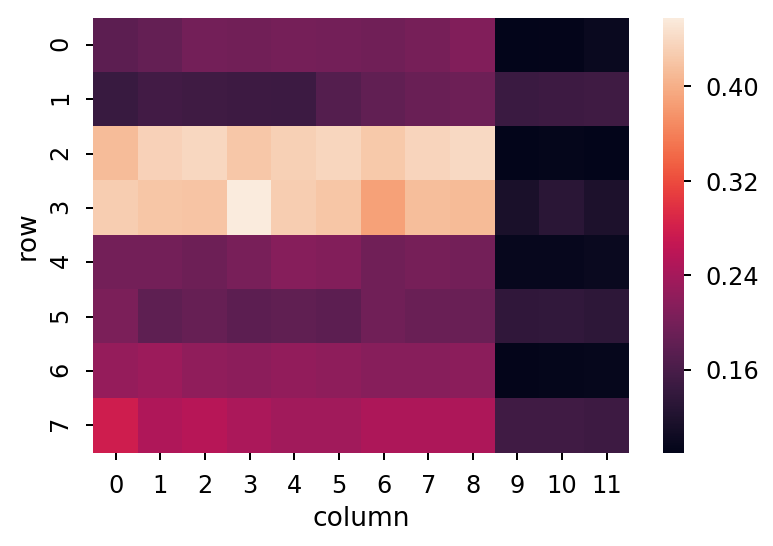

In [242]:
g = sns.heatmap(data=data.pivot('row','column','OD600'))

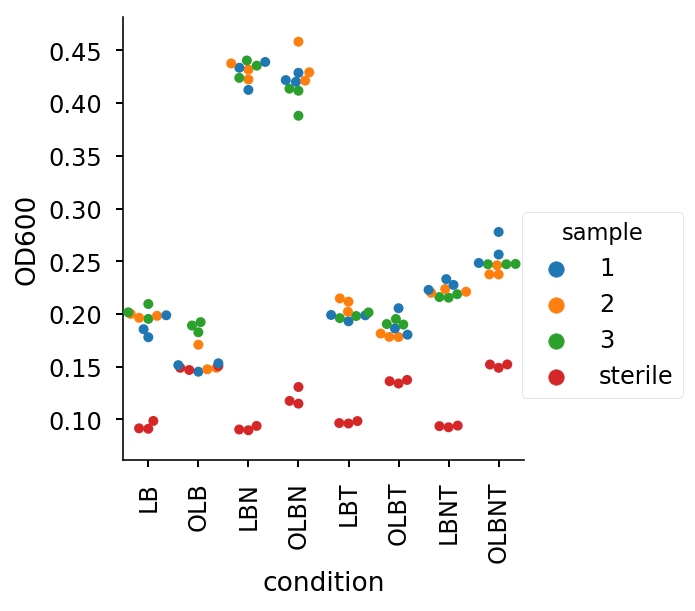

In [243]:
g = sns.factorplot(data=data,hue="sample",x="condition",y="OD600",kind="swarm")
g.set_xticklabels(rotation=90)

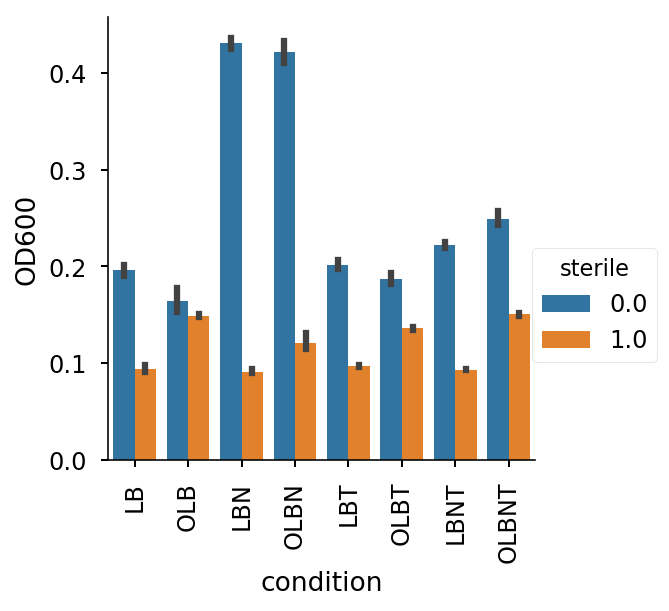

In [263]:
g = sns.factorplot(data=data,hue="sterile",x="condition",y="OD600",kind="bar")
g.set_xticklabels(rotation=90)

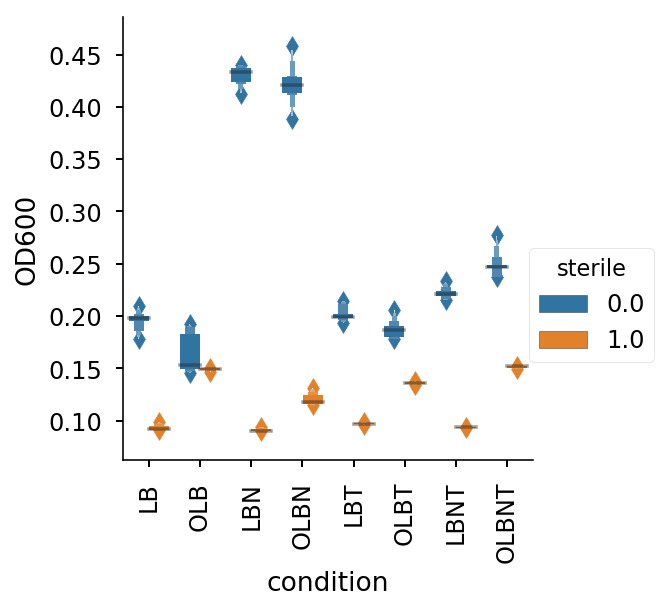

In [254]:
g = sns.factorplot(data=data,hue="sterile",x="condition",y="OD600",kind="lv",linewidth=0.5)
g.set_xticklabels(rotation=90)

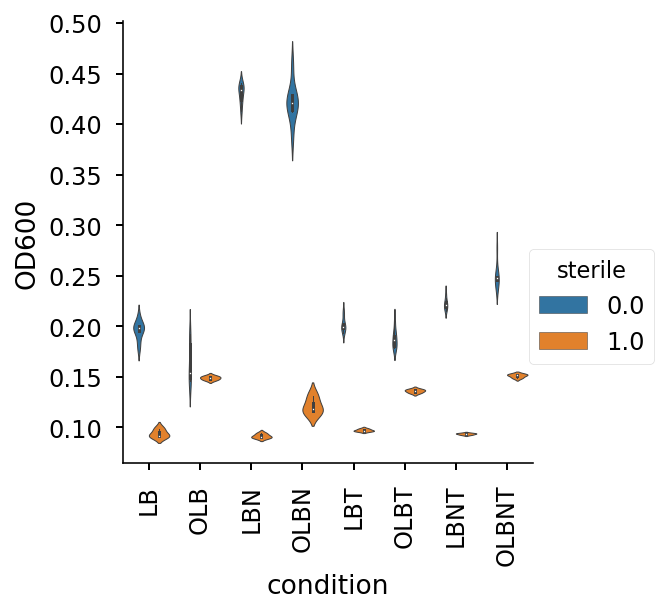

In [253]:
g = sns.factorplot(data=data,hue="sterile",x="condition",y="OD600",kind="violin",linewidth=0.5)
g.set_xticklabels(rotation=90)

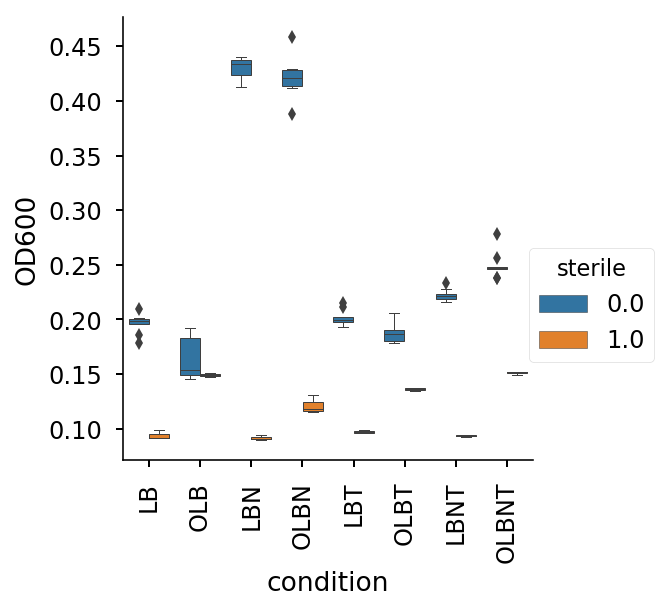

In [248]:
g = sns.factorplot(data=data,hue="sterile",x="condition",y="OD600",kind="box",linewidth=0.5)
g.set_xticklabels(rotation=90)

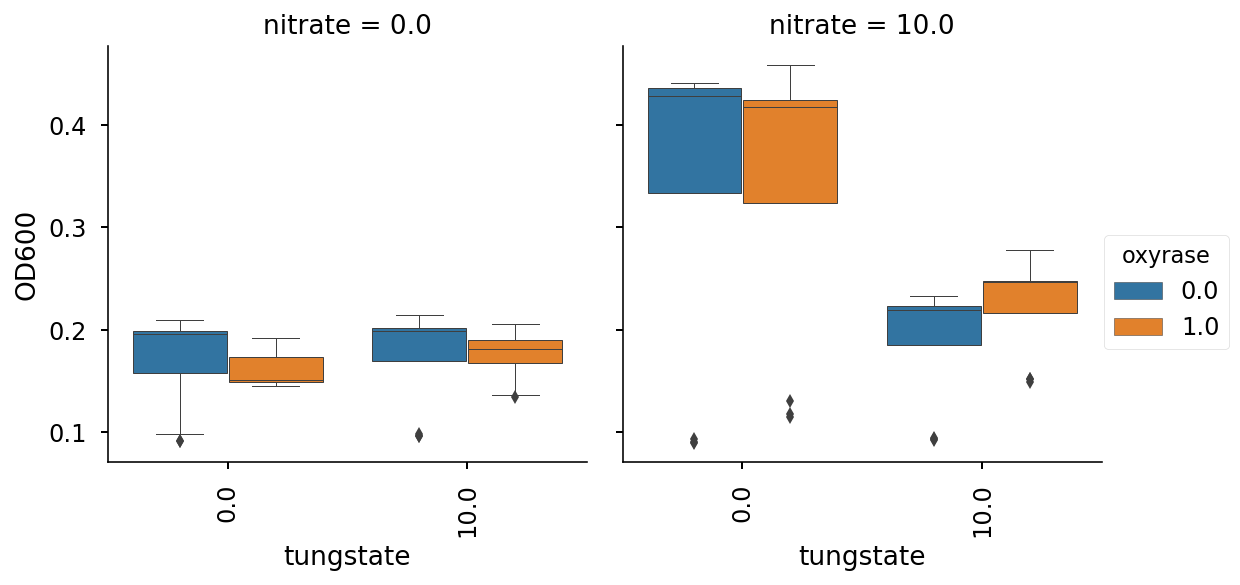

In [264]:
g = sns.factorplot(data=data,hue="oxyrase",x="tungstate",y="OD600",col="nitrate", kind="box",linewidth=0.5)
g.set_xticklabels(rotation=90)

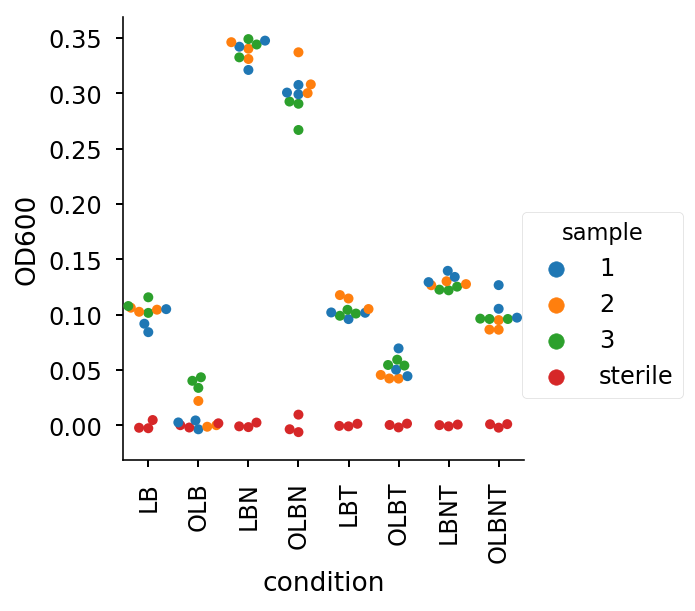

In [261]:
import plates.data
data_normalized_sterile = plates.data.calc_norm(data,value='OD600',
                                    on='sample',columns=['condition'], 
                                    how=lambda x: x - x.loc['sterile'].mean())

g = sns.factorplot(data=data_normalized_sterile,hue="sample",x="condition",y="OD600",kind="swarm",
                   order=["LB","OLB","LBN","OLBN","LBT","OLBT","LBNT","OLBNT"])
g.set_xticklabels(rotation=90)

## Case 2

In [55]:
# load data from Excel file
data = pd.read_excel('./data/2018-03-29_CG007e.xlsx',
              sheet_name=0, header=36, skipfooter=4, index_col=0)

# Extract temperature vs. time as separate variable, then drop (delete)
# it from the main data frame
temps = data.loc['Temp. [°C]',:]
data = data.drop('Temp. [°C]')

# collect data into "tidy" format, with one row per observation, 
# one column for each variable (well, time, OD600)
data.columns = data.columns.rename('time')
data.index = data.index.rename('well')
data = data.reset_index()
data = data.melt(id_vars=['well'],value_name='OD600')

# build platemap with relevant metadata
platemap = plates.spec96to384(plates.prog2spec({
    "A:A,H:H,1:1,12:12": { "sterile":1 },
    "B2:G11":            { "sterile":0 },
    
    "B2:G3":   { "strain":"PAO1" , "phenotype":"susceptible" },
    "B4:G5":   { "strain":"30"   , "phenotype":"susceptible" },
    "B6:G7":   { "strain":"31"   , "phenotype":"susceptible" },
    "B8:G9":   { "strain":"35"   , "phenotype":"susceptible" },
    
    "2:2,4:4,6:6,8:8,10:10": { "tungstate":0  },
    "3:3,5:5,7:7,9:9,11:11": { "tungstate":10 },
    
    "B:B": { "dilution":2**-0 },
    "C:C": { "dilution":2**-1 },
    "D:D": { "dilution":2**-2 },
    "E:E": { "dilution":2**-3 },
    "F:F": { "dilution":2**-4 },
    "G:G": { "dilution":2**-5 }
}, include_row_column=True))

# join platemap to the raw data
data = pd.merge(data,platemap, how='inner', left_on='well',right_index=True)


# convert time series data from seconds to hours
data['time'] = data['time']/3600.0

# anything not specifically marked as sterile was innoculated
# data = data.fillna(value={'sterile':0})

In [56]:
data.dropna().head()

,well,time,OD600,row,column,sterile,strain,phenotype,tungstate,dilution
50,C3,0,0.1173,2,2,0,PAO1,susceptible,0,1
434,C3,0.191722,0.1160,2,2,0,PAO1,susceptible,0,1
818,C3,0.383417,0.1191,2,2,0,PAO1,susceptible,0,1
1202,C3,0.575139,0.1220,2,2,0,PAO1,susceptible,0,1
1586,C3,0.766833,0.1196,2,2,0,PAO1,susceptible,0,1


In [57]:
data.describe()

,OD600
count,39552.000000
mean,0.203752
std,0.106334
min,0.097900
25%,0.120600
50%,0.140100
75%,0.339200
max,0.438100


In [58]:
data.describe(exclude=[np.number])

,well,time,row,column,sterile,strain,phenotype,tungstate,dilution
count,39552,39552.000,39552,39552,39552.0,19776,19776,32960.0,29664.00000
unique,384,103.000,16,24,2.0,4,1,2.0,6.00000
top,L14,2.876,15,23,0.0,31,susceptible,10.0,0.03125
freq,103,384.000,2472,1648,24720.0,4944,19776,16480.0,4944.00000


## Plotting

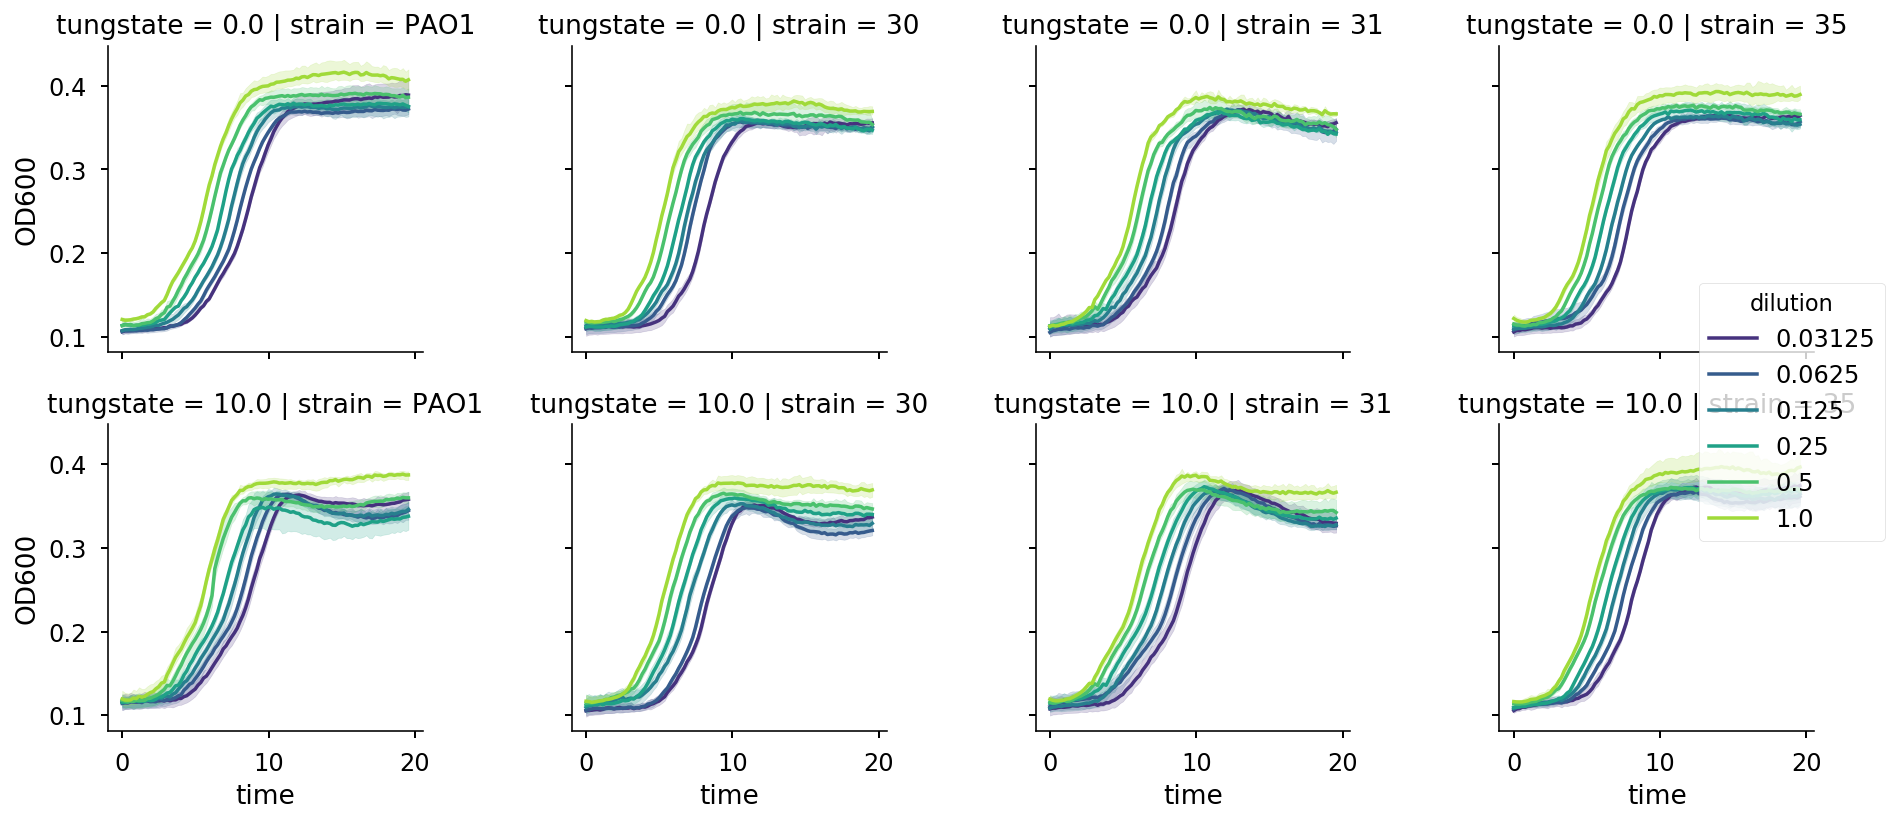

In [30]:
# Look at each strain in each condition, overlaying dilutions
g = sns.FacetGrid(data=data.query('sterile == 0'),
                  col='strain',row='tungstate',hue='dilution',
                  palette='viridis')
g.map_dataframe(sns.lineplot,'time','OD600',legend='full')
g.add_legend()
g.fig.tight_layout()

In [66]:
data = data.apply(pd.to_numeric,errors='ignore')

In [76]:
stat_smooth?

/Users/caseygrun/miniconda3/envs/kaz_lab_workshop/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/caseygrun/miniconda3/envs/kaz_lab_workshop/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/caseygrun/miniconda3/envs/kaz_lab_workshop/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


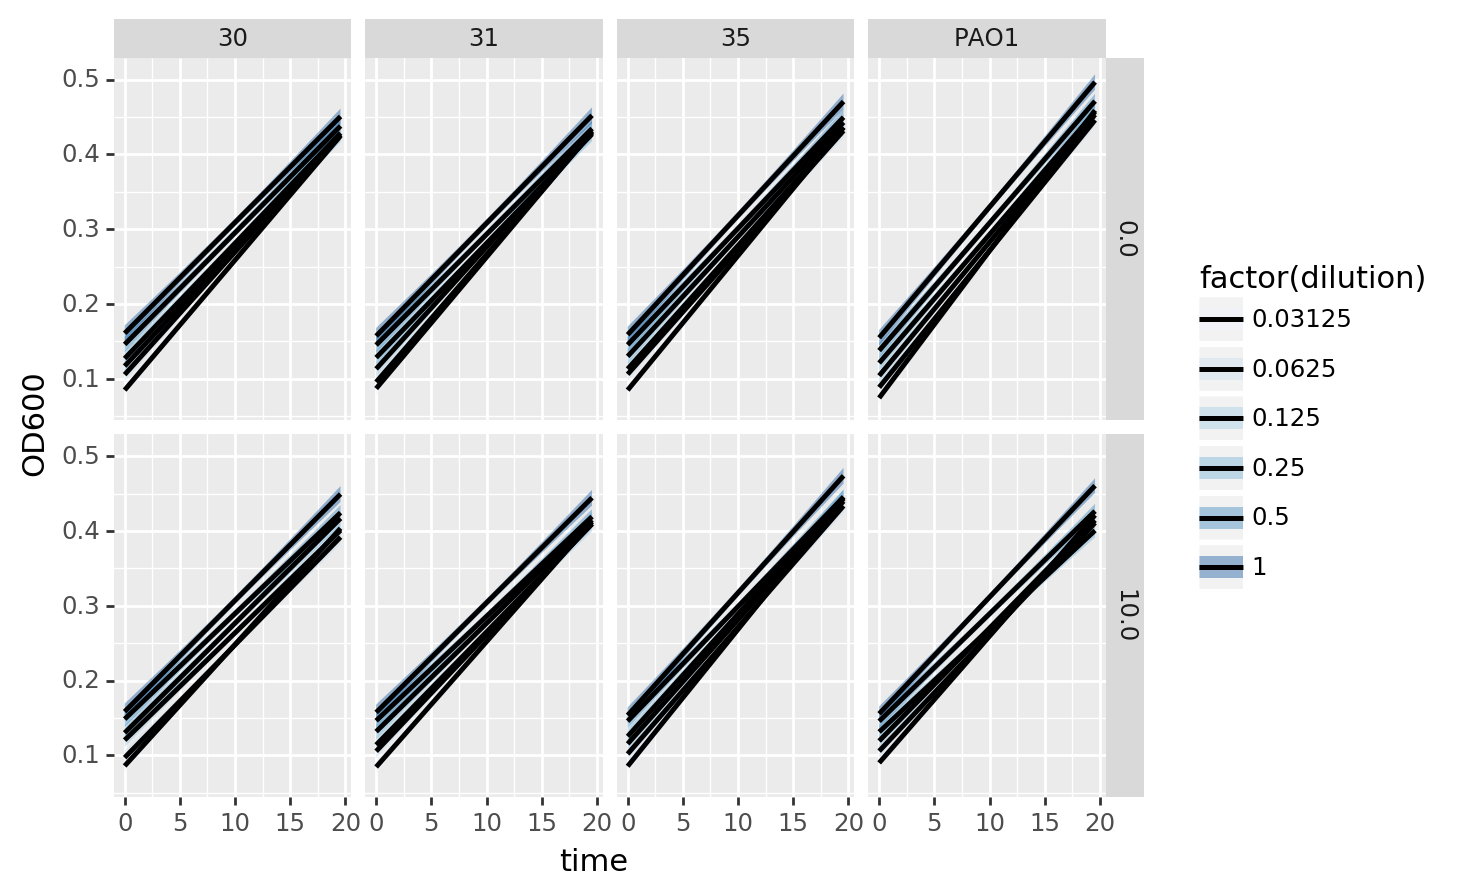

<ggplot: (-9223372036558670918)>

In [88]:
(ggplot(data.query('sterile == 0').dropna(), aes('time', 'OD600',fill='factor(dilution)'))
#  + geom_point()
 + scale_x_continuous(breaks=range(0,25,5))
 + geom_smooth(method='glm')
#  + stat_smooth(method='mavg',method_args={'window':10})
#  + stat_smooth()
 + scale_fill_brewer()
#  + stat_smooth(method='lm')
 + facet_grid('tungstate ~ strain'))

/Users/caseygrun/miniconda3/envs/kaz_lab_workshop/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/caseygrun/miniconda3/envs/kaz_lab_workshop/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/caseygrun/miniconda3/envs/kaz_lab_workshop/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


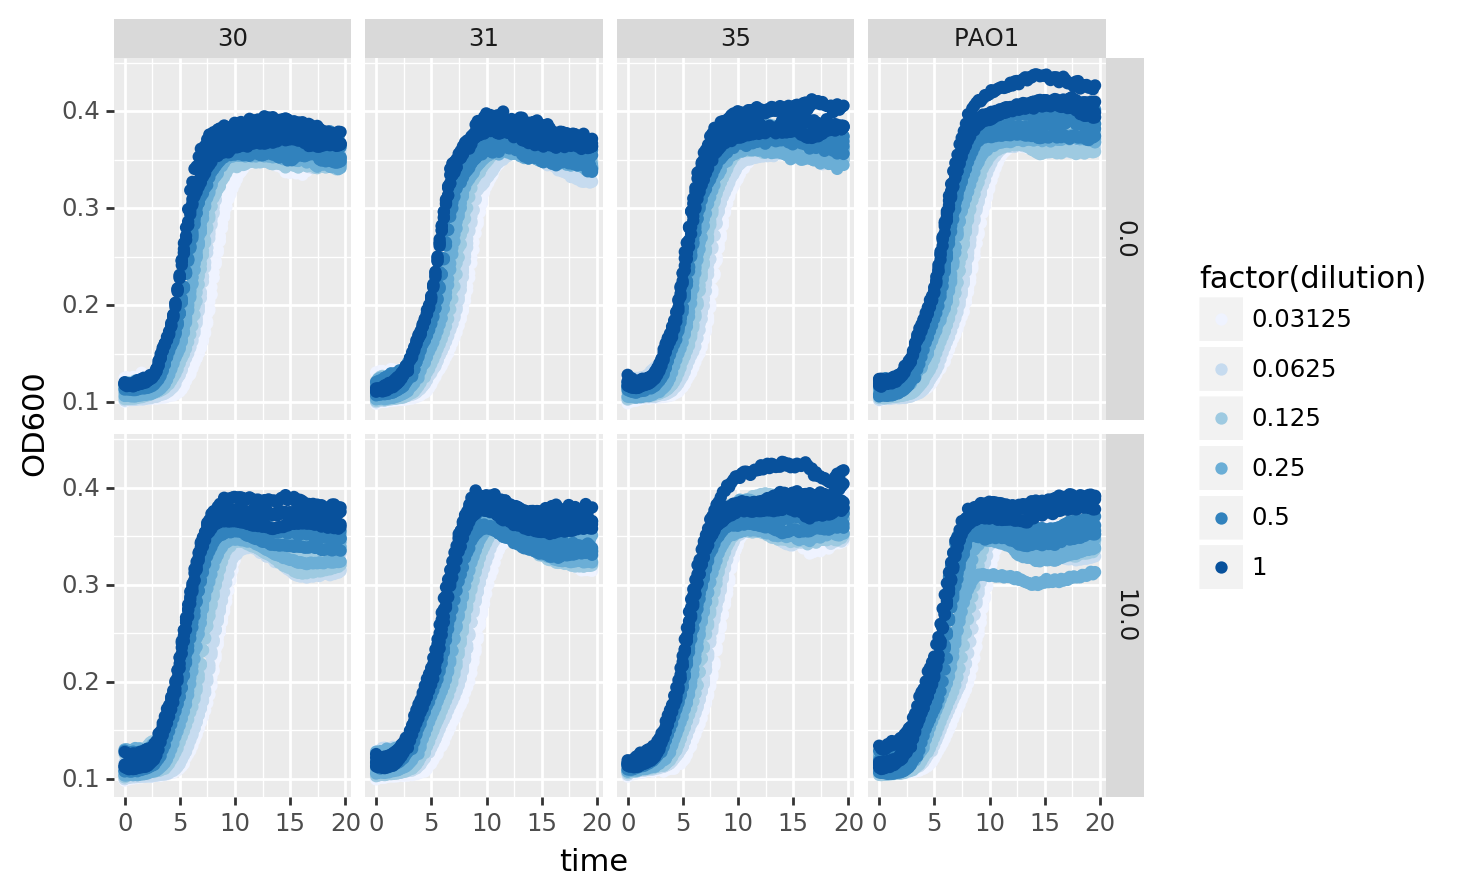

<ggplot: (-9223372036553289577)>

In [73]:
(ggplot(data.query('sterile == 0').dropna(), aes('time', 'OD600',color='factor(dilution)'))
 + geom_point()
 + scale_x_continuous(breaks=range(0,25,5))
 + scale_color_brewer()
#  + geom_smooth()
#  + stat_smooth(method='lm')
 + facet_grid('tungstate ~ strain'))

/Users/caseygrun/miniconda3/envs/kaz_lab_workshop/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/caseygrun/miniconda3/envs/kaz_lab_workshop/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/caseygrun/miniconda3/envs/kaz_lab_workshop/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


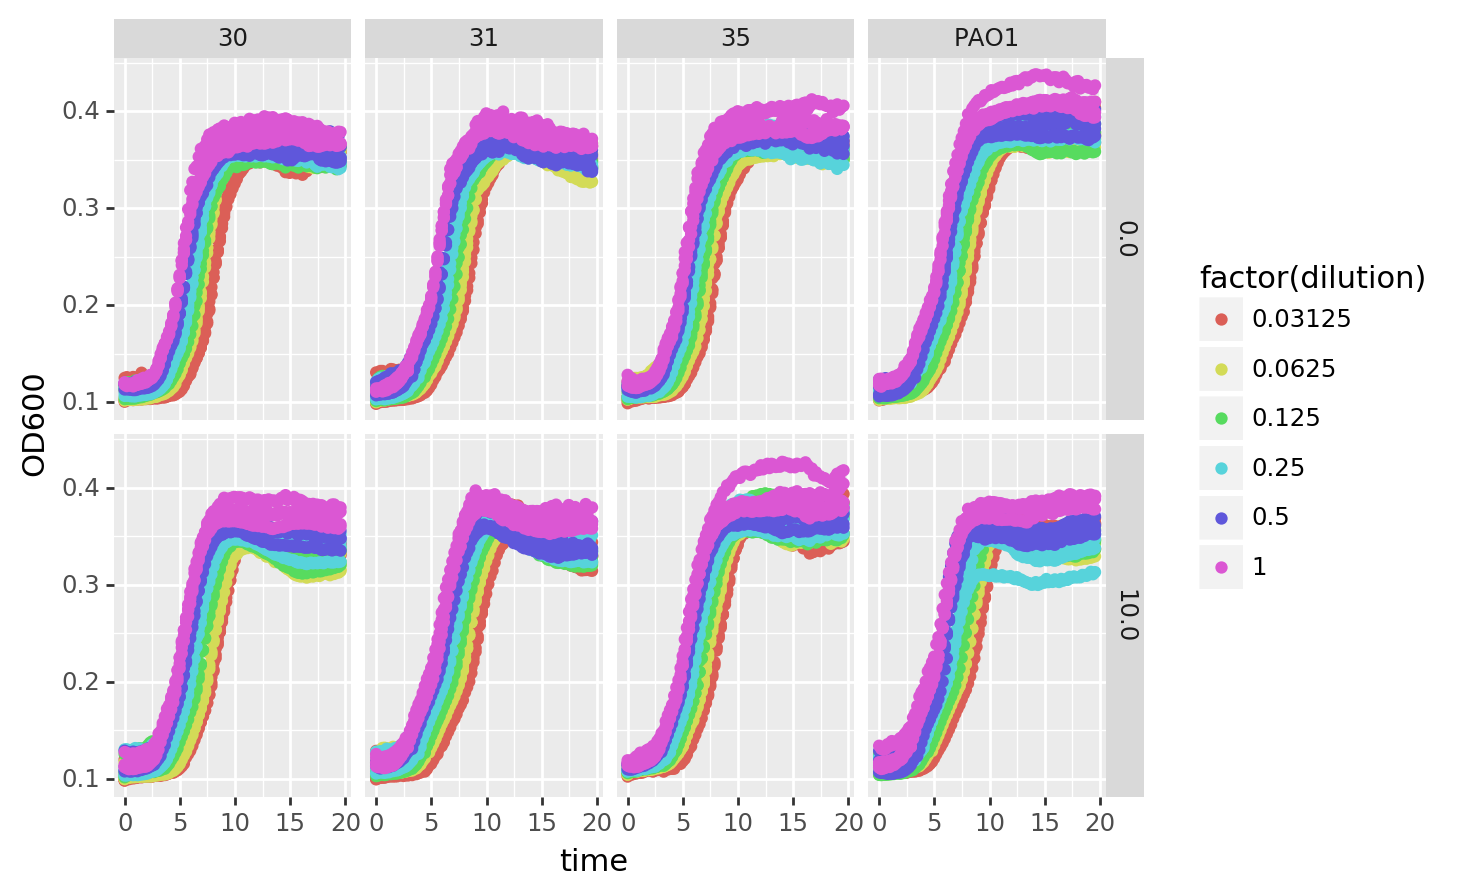

<ggplot: (-9223372036557108143)>

In [69]:
(ggplot(data.query('sterile == 0').dropna(), aes('time', 'OD600',color='factor(dilution)'))
 + geom_point()
 + scale_x_continuous(breaks=range(0,25,5))
 + scale_color_discrete()
#  + geom_smooth()
#  + stat_smooth(method='lm')
 + facet_grid('tungstate ~ strain'))

## Example 2: Amoeba Data

Goal: The goal of this experiment was to explore how co-incubation of two strains of _P. aeruginosa_---PA103 and PA14 FliF were affected by growth in the presence of _Acanthamoeba castelanii_.

Let's start by building the plate map this time. The general layout of the plate is as follows:

|            |   1    |   3    |   2    |   4    |   5    |   6    |   |     7     |     8     |     9     |     10    |     11    |     12    |  _Ac_  |
|------------|--------|--------|--------|--------|--------|--------|---|-----------|-----------|-----------|-----------|-----------|-----------|--------|
| **Strain** | PA103  | PA103  | PA103  | PA103  | PA103  | PA103  |   | PA14 FliF | PA14 FliF | PA14 FliF | PA14 FliF | PA14 FliF | PA14 FliF |        |
| **A**      | $10^3$ | $10^3$ | $10^3$ | $10^4$ | $10^4$ | $10^4$ |   | $10^4$    | $10^4$    | $10^4$    | $10^3$    | $10^3$    | $10^3$    | $0$    |
| **B**      | $100$  | $100$  | $100$  | $10$   | $10$   | $10$   |   | $100$     | $100$     | $100$     | $10$      | $10$      | $10$      | $0$    |
| **C**      | $10^3$ | $10^3$ | $10^3$ | $10^4$ | $10^4$ | $10^4$ |   | $10^4$    | $10^4$    | $10^4$    | $10^3$    | $10^3$    | $10^3$    | $100$  |
| **D**      | $100$  | $100$  | $100$  | $10$   | $10$   | $10$   |   | $100$     | $100$     | $100$     | $10$      | $10$      | $10$      | $100$  |
| **E**      | $10^3$ | $10^3$ | $10^3$ | $10^4$ | $10^4$ | $10^4$ |   | $10^4$    | $10^4$    | $10^4$    | $10^3$    | $10^3$    | $10^3$    | $10^3$ |
| **F**      | $100$  | $100$  | $100$  | $10$   | $10$   | $10$   |   | $100$     | $100$     | $100$     | $10$      | $10$      | $10$      | $10^3$ |
| **G**      | $10^3$ | $10^3$ | $10^3$ | $10^4$ | $10^4$ | $10^4$ |   | $10^4$    | $10^4$    | $10^4$    | $10^3$    | $10^3$    | $10^3$    | $10^4$ |
| **H**      | $100$  | $100$  | $100$  | $10$   | $10$   | $10$   |   | $100$     | $100$     | $100$     | $10$      | $10$      | $10$      | $10^4$ |


In [171]:
platemap = plates.prog2spec({
    "1:6":  { "strain": "PA103" },
    "7:12": { "strain": "PA14 FliF" },
    "A:B":  { "Ac_inoculum": 0 },
    "C:D":  { "Ac_inoculum": 100 },
    "E:F":  { "Ac_inoculum": 10**3 },
    "G:H":  { "Ac_inoculum": 10**4 },
    "A:B,C:D,E:F,G:H": { "Pa_inoculum": [ 
        [ 10**3, 10**3, 10**3, 10**4, 10**4, 10**4, 10**4, 10**4, 10**4, 10**3, 10**3, 10**3 ],
        [ 100,   100,   100,   10,    10,    10,    100,   100,   100,   10,    10,    10,   ]
    ] }
}, include_row_column=True)
display(platemap.head())
display(platemap.tail())

,row,column,strain,Ac_inoculum,Pa_inoculum
A1,0.0,0.0,PA103,0.0,1000.0
A2,0.0,1.0,PA103,0.0,1000.0
A3,0.0,2.0,PA103,0.0,1000.0
A4,0.0,3.0,PA103,0.0,10000.0
A5,0.0,4.0,PA103,0.0,10000.0


,row,column,strain,Ac_inoculum,Pa_inoculum
H8,7.0,7.0,PA14 FliF,10000.0,100.0
H9,7.0,8.0,PA14 FliF,10000.0,100.0
H10,7.0,9.0,PA14 FliF,10000.0,10.0
H11,7.0,10.0,PA14 FliF,10000.0,10.0
H12,7.0,11.0,PA14 FliF,10000.0,10.0


In [172]:
df1 = pd.read_excel('./data/5.5.18_growth curve_25C_PYG_121 hrs_Ac + PA103, PA14 FliF_MASTER.xlsx',
                    index_col=0,
                    header=2,
                    nrows=98,
                    usecols=plates.letters2row('EC'))
display(df1.head())
display(df1.tail())

,0.0,655.8,1311.6,1967.4,2623.2,3279.1,3935.0,4590.8,5246.6,5902.4,...,80010.7,80666.5,81322.3,81978.1,82633.9,83289.7,83945.5,84601.3,85257.1,85912.9
Time [s],,,,,,,,,,,,,,,,,,,,,
Time [hrs],0.0000,0.182167,0.364333,0.5465,0.728667,0.910861,1.093056,1.275222,1.457389,1.639556,...,22.225194,22.407361,22.589528,22.771694,22.953861,23.136028,23.318194,23.500361,23.682528,23.864694
Temp. [°C],25.0000,25.100000,25.000000,25.0000,25.200000,25.300000,25.200000,25.100000,24.900000,25.100000,...,25.200000,25.400000,25.100000,25.100000,25.300000,25.300000,25.300000,25.300000,25.300000,25.400000
A1,0.0854,0.087400,0.087100,0.0880,0.088200,0.087900,0.088600,0.087900,0.087500,0.088100,...,0.430300,0.434700,0.442600,0.449800,0.452300,0.459100,0.466100,0.472300,0.480600,0.483600
A2,0.0859,0.088800,0.088600,0.0881,0.087600,0.087100,0.087300,0.089000,0.086600,0.087600,...,0.438700,0.445500,0.452300,0.459200,0.464300,0.471900,0.473800,0.482900,0.489600,0.495800
A3,0.0882,0.088300,0.088800,0.0891,0.088700,0.088200,0.088200,0.088000,0.087400,0.088400,...,0.449500,0.453500,0.463200,0.465700,0.468600,0.480400,0.480500,0.489100,0.494800,0.503200


,0.0,655.8,1311.6,1967.4,2623.2,3279.1,3935.0,4590.8,5246.6,5902.4,...,80010.7,80666.5,81322.3,81978.1,82633.9,83289.7,83945.5,84601.3,85257.1,85912.9
Time [s],,,,,,,,,,,,,,,,,,,,,
H8,0.1045,0.1093,0.1016,0.1008,0.0984,0.0956,0.0977,0.0955,0.0966,0.0969,...,0.1408,0.1439,0.1480,0.1523,0.1560,0.1606,0.1643,0.1687,0.1720,0.1780
H9,0.1024,0.1048,0.1004,0.1032,0.0992,0.0979,0.0981,0.0975,0.0977,0.0976,...,0.1500,0.1528,0.1573,0.1619,0.1659,0.1705,0.1744,0.1782,0.1827,0.1886
H10,0.1066,0.1001,0.0969,0.0966,0.0954,0.0952,0.0961,0.0955,0.0953,0.0939,...,0.1184,0.1193,0.1218,0.1246,0.1265,0.1293,0.1306,0.1315,0.1339,0.1371
H11,0.0959,0.0940,0.0941,0.0937,0.0934,0.0935,0.0947,0.0939,0.0936,0.0940,...,0.1121,0.1128,0.1132,0.1136,0.1156,0.1162,0.1188,0.1185,0.1211,0.1226
H12,0.0919,0.0918,0.0922,0.0927,0.0927,0.0924,0.0930,0.0928,0.0918,0.0929,...,0.1096,0.1108,0.1115,0.1127,0.1136,0.1142,0.1152,0.1178,0.1194,0.1209


In [173]:
df2 = pd.read_excel('./data/5.5.18_growth curve_25C_PYG_121 hrs_Ac + PA103, PA14 FliF_MASTER.xlsx',
                    index_col=0,
                    header=104,
                    nrows=98,
                    usecols=plates.letters2row('EC'))

In [174]:
df3 = pd.read_excel('./data/5.5.18_growth curve_25C_PYG_121 hrs_Ac + PA103, PA14 FliF_MASTER.xlsx',
                    index_col=0,
                    header=206,
                    nrows=98,
                    usecols=plates.letters2row('CT'))

In [175]:
df4 = pd.read_excel('./data/5.5.18_growth curve_25C_PYG_121 hrs_Ac + PA103, PA14 FliF_MASTER.xlsx',
                    index_col=0,
                    header=309,
                    nrows=98,
                    usecols=3)

In [176]:
df5 = pd.read_excel('./data/5.5.18_growth curve_25C_PYG_121 hrs_Ac + PA103, PA14 FliF_MASTER.xlsx',
                    index_col=0,
                    header=412,
                    nrows=98,
                    usecols=3)

In [114]:
df6 = pd.read_excel('./data/5.5.18_growth curve_25C_PYG_121 hrs_Ac + PA103, PA14 FliF_MASTER.xlsx',
                    index_col=0,
                    header=514,
                    nrows=98,
                    usecols=4)

In [177]:
offset = 0

dfs = []

for df in [df1, df2, df3]:
    display(df.head())
    display(df.tail())
    print('----')
    
    # Extract temperature vs. time as separate variable, then drop (delete)
    # it from the main data frame
    temps = df.loc['Temp. [°C]',:]
    df = df.drop('Temp. [°C]')

    # likewise, extract the seconds column
    time_h = df.loc['Time [hrs]',:]
    df = df.drop('Time [hrs]')

    # convert columns to hours, and add offset
    df.columns = (df.columns / 3600) + offset

    # the offset for the next table will be the last time point for this table
    offset = df.columns[-1]

    # collect df into "tidy" format, with one row per observation, 
    # one column for each variable (well, time, OD600)
    df.columns = df.columns.rename('time')
    df.index = df.index.rename('well')
    df = df.reset_index()
    df = df.melt(id_vars=['well'],value_name='OD600')
    
    # join platemap to the raw data
    df = pd.merge(df,platemap, how='inner', left_on='well',right_index=True)
    
    dfs.append(df)
    

for df, offset in zip([df4, df5, df6], [88.5, 112, 121]):
    display(df.head())
    display(df.tail())
    print('----')
    # Extract temperature vs. time as separate variable, then drop (delete)
    # it from the main data frame
    temps = df.loc['Temp. [°C]',:]
    df = df.drop('Temp. [°C]')

    # likewise, extract the seconds column
    time_h = df.loc['Time [hrs]',:]
    df = df.drop('Time [hrs]')

    # convert columns to hours, and add offset
    df.columns = (df.columns / 3600) + offset
    
    # collect df into "tidy" format, with one row per observation, 
    # one column for each variable (well, time, OD600)
    df.columns = df.columns.rename('time')
    df.index = df.index.rename('well')
    df = df.reset_index()
    df = df.melt(id_vars=['well'],value_name='OD600')
    
    # join platemap to the raw data
    df = pd.merge(df,platemap, how='inner', left_on='well',right_index=True)
    
    dfs.append(df)
    
data = pd.concat(dfs)
    
display(data.head())
display(data.tail())

,0.0,655.8,1311.6,1967.4,2623.2,3279.1,3935.0,4590.8,5246.6,5902.4,...,80010.7,80666.5,81322.3,81978.1,82633.9,83289.7,83945.5,84601.3,85257.1,85912.9
Time [s],,,,,,,,,,,,,,,,,,,,,
Time [hrs],0.0000,0.182167,0.364333,0.5465,0.728667,0.910861,1.093056,1.275222,1.457389,1.639556,...,22.225194,22.407361,22.589528,22.771694,22.953861,23.136028,23.318194,23.500361,23.682528,23.864694
Temp. [°C],25.0000,25.100000,25.000000,25.0000,25.200000,25.300000,25.200000,25.100000,24.900000,25.100000,...,25.200000,25.400000,25.100000,25.100000,25.300000,25.300000,25.300000,25.300000,25.300000,25.400000
A1,0.0854,0.087400,0.087100,0.0880,0.088200,0.087900,0.088600,0.087900,0.087500,0.088100,...,0.430300,0.434700,0.442600,0.449800,0.452300,0.459100,0.466100,0.472300,0.480600,0.483600
A2,0.0859,0.088800,0.088600,0.0881,0.087600,0.087100,0.087300,0.089000,0.086600,0.087600,...,0.438700,0.445500,0.452300,0.459200,0.464300,0.471900,0.473800,0.482900,0.489600,0.495800
A3,0.0882,0.088300,0.088800,0.0891,0.088700,0.088200,0.088200,0.088000,0.087400,0.088400,...,0.449500,0.453500,0.463200,0.465700,0.468600,0.480400,0.480500,0.489100,0.494800,0.503200


,0.0,655.8,1311.6,1967.4,2623.2,3279.1,3935.0,4590.8,5246.6,5902.4,...,80010.7,80666.5,81322.3,81978.1,82633.9,83289.7,83945.5,84601.3,85257.1,85912.9
Time [s],,,,,,,,,,,,,,,,,,,,,
H8,0.1045,0.1093,0.1016,0.1008,0.0984,0.0956,0.0977,0.0955,0.0966,0.0969,...,0.1408,0.1439,0.1480,0.1523,0.1560,0.1606,0.1643,0.1687,0.1720,0.1780
H9,0.1024,0.1048,0.1004,0.1032,0.0992,0.0979,0.0981,0.0975,0.0977,0.0976,...,0.1500,0.1528,0.1573,0.1619,0.1659,0.1705,0.1744,0.1782,0.1827,0.1886
H10,0.1066,0.1001,0.0969,0.0966,0.0954,0.0952,0.0961,0.0955,0.0953,0.0939,...,0.1184,0.1193,0.1218,0.1246,0.1265,0.1293,0.1306,0.1315,0.1339,0.1371
H11,0.0959,0.0940,0.0941,0.0937,0.0934,0.0935,0.0947,0.0939,0.0936,0.0940,...,0.1121,0.1128,0.1132,0.1136,0.1156,0.1162,0.1188,0.1185,0.1211,0.1226
H12,0.0919,0.0918,0.0922,0.0927,0.0927,0.0924,0.0930,0.0928,0.0918,0.0929,...,0.1096,0.1108,0.1115,0.1127,0.1136,0.1142,0.1152,0.1178,0.1194,0.1209


----


,0.0,655.7,1311.5,1967.3,2623.2,3279.0,3934.7,4590.5,5246.2,5902.0,...,80003.0,80658.8,81314.5,81970.3,82626.0,83281.8,83937.5,84593.5,85249.2,85905.0
Time [s],,,,,,,,,,,,,,,,,,,,,
Time [hrs],23.86469,24.046829,24.228996,24.411162,24.593357,24.775523,24.957662,25.139829,25.321968,25.504134,...,46.087746,46.269912,46.452051,46.634218,46.816357,46.998523,47.180662,47.362884,47.545023,47.72719
Temp. [°C],25.20000,25.400000,25.200000,25.300000,25.100000,25.200000,24.900000,25.100000,25.100000,25.100000,...,25.200000,25.400000,25.400000,25.400000,25.400000,25.500000,25.400000,25.400000,25.400000,25.30000
A1,0.49240,0.496700,0.501200,0.505200,0.511600,0.513100,0.518300,0.521400,0.526400,0.528800,...,0.807000,0.813800,0.804900,0.815700,0.811200,0.813000,0.821400,0.813300,0.811800,0.81560
A2,0.50940,0.508100,0.515700,0.520500,0.525200,0.529500,0.536800,0.540600,0.545500,0.547300,...,0.819200,0.820200,0.820800,0.821000,0.819300,0.822100,0.830100,0.827000,0.830700,0.83020
A3,0.51950,0.513000,0.523900,0.525300,0.532700,0.537600,0.542500,0.545800,0.550400,0.552400,...,0.817400,0.816900,0.819200,0.821500,0.821400,0.823200,0.830800,0.829200,0.831400,0.83280


,0.0,655.7,1311.5,1967.3,2623.2,3279.0,3934.7,4590.5,5246.2,5902.0,...,80003.0,80658.8,81314.5,81970.3,82626.0,83281.8,83937.5,84593.5,85249.2,85905.0
Time [s],,,,,,,,,,,,,,,,,,,,,
H8,0.1820,0.1865,0.1917,0.1952,0.1993,0.2056,0.2104,0.2129,0.2184,0.2243,...,0.7151,0.7182,0.7249,0.7271,0.7302,0.7296,0.7357,0.7350,0.7342,0.7428
H9,0.1913,0.1976,0.2019,0.2057,0.2093,0.2160,0.2206,0.2244,0.2282,0.2351,...,0.7254,0.7290,0.7316,0.7353,0.7390,0.7375,0.7406,0.7415,0.7409,0.7485
H10,0.1394,0.1430,0.1466,0.1496,0.1524,0.1577,0.1605,0.1642,0.1691,0.1726,...,0.6620,0.6648,0.6694,0.6754,0.6793,0.6796,0.6831,0.6876,0.6858,0.6867
H11,0.1249,0.1267,0.1292,0.1301,0.1314,0.1345,0.1368,0.1398,0.1429,0.1458,...,0.6354,0.6361,0.6380,0.6409,0.6472,0.6506,0.6504,0.6617,0.6602,0.6625
H12,0.1219,0.1244,0.1264,0.1285,0.1303,0.1329,0.1356,0.1385,0.1415,0.1451,...,0.5489,0.5423,0.5517,0.5494,0.5572,0.5584,0.5602,0.5617,0.5603,0.5649


----


,0.0,656.1,1311.8,1967.6,2623.3,3279.1,3934.9,4590.7,5246.5,5902.3,...,57052.7,57708.5,58364.2,59020.0,59675.7,60331.5,60987.2,61643.0,62298.7,62954.5
Time [s],,,,,,,,,,,,,,,,,,,,,
Time [hrs],47.72719,47.90944,48.091579,48.273746,48.455884,48.638051,48.820218,49.002384,49.184551,49.366718,...,63.575162,63.757329,63.939468,64.121634,64.303773,64.48594,64.668079,64.850246,65.032384,65.214551
Temp. [°C],25.10000,25.20000,25.300000,25.400000,24.900000,25.400000,25.100000,25.200000,25.200000,24.900000,...,25.100000,25.400000,25.000000,25.200000,25.300000,25.50000,25.300000,25.500000,25.500000,25.500000
A1,0.80840,0.82830,0.830400,0.819400,0.823200,0.836700,0.835700,0.831800,0.826400,0.835600,...,0.944500,0.948000,0.963900,0.960000,0.958600,0.96300,0.962700,0.963200,0.967100,0.973400
A2,0.83350,0.83720,0.836800,0.838300,0.843800,0.846900,0.847600,0.852500,0.854200,0.850400,...,1.013500,1.012000,1.020700,1.023500,1.021700,1.02250,1.025100,1.025900,1.028500,1.034700
A3,0.84060,0.84020,0.839300,0.844100,0.845800,0.845200,0.845500,0.846000,0.849000,0.849800,...,1.016300,1.010900,1.013600,1.021400,1.022500,1.02340,1.027300,1.027200,1.032700,1.035100


,0.0,656.1,1311.8,1967.6,2623.3,3279.1,3934.9,4590.7,5246.5,5902.3,...,57052.7,57708.5,58364.2,59020.0,59675.7,60331.5,60987.2,61643.0,62298.7,62954.5
Time [s],,,,,,,,,,,,,,,,,,,,,
H8,0.7457,0.7484,0.7518,0.7481,0.7530,0.7583,0.7570,0.7613,0.7591,0.7649,...,0.9571,0.9573,0.9674,0.9643,0.9661,0.9683,0.9699,0.9677,0.9699,0.9755
H9,0.7467,0.7470,0.7523,0.7560,0.7608,0.7615,0.7578,0.7684,0.7640,0.7715,...,0.9655,0.9681,0.9671,0.9706,0.9730,0.9810,0.9795,0.9782,0.9739,0.9820
H10,0.6940,0.6956,0.6976,0.7041,0.7031,0.7067,0.7044,0.7102,0.7094,0.7162,...,0.9082,0.9145,0.9198,0.9163,0.9212,0.9307,0.9210,0.9263,0.9210,0.9223
H11,0.6652,0.6699,0.6698,0.6719,0.6769,0.6793,0.6781,0.6845,0.6866,0.6949,...,0.8738,0.8746,0.8787,0.8837,0.8822,0.8831,0.8800,0.8893,0.8905,0.8870
H12,0.5684,0.5720,0.5674,0.5684,0.5741,0.5738,0.5831,0.5926,0.5790,0.6007,...,0.6975,0.7002,0.7126,0.7061,0.7098,0.7071,0.6994,0.7247,0.7047,0.7027


----


,0.0,655.7,1311.5
Time [s],,,
Time [hrs],88.5000,88.682139,88.864306
Temp. [°C],25.1000,25.400000,25.000000
A1,1.3922,1.204100,1.109000
A2,1.3662,1.515500,1.522700
A3,1.3836,1.558900,1.567500


,0.0,655.7,1311.5
Time [s],,,
H8,1.3036,1.2445,1.2395
H9,1.3362,1.2535,1.2593
H10,1.2005,1.1882,1.1767
H11,1.1152,1.1361,1.1466
H12,0.8240,0.8327,0.8102


----


,0.0,656.0,1311.8
Time [s],,,
Time [hrs],112.0000,112.182222,112.364389
Temp. [°C],25.0000,25.100000,25.100000
A1,1.3658,0.994700,1.014300
A2,1.5609,1.523800,1.586400
A3,1.5606,1.587300,1.619700


,0.0,656.0,1311.8
Time [s],,,
H8,1.6203,1.4746,1.4745
H9,1.5644,1.5173,1.5364
H10,1.4277,1.4138,1.4107
H11,1.2907,1.3801,1.3928
H12,0.4338,0.4926,0.4659


----


,0.0,175.8,351.6,527.3
Time [s],,,,
Time [hrs],121.0000,121.048833,121.097667,121.146472
Temp. [°C],24.9000,25.200000,25.300000,25.400000
A1,1.1190,0.915100,0.924000,0.926600
A2,1.5691,1.589900,1.567400,1.542700
A3,1.5457,1.538300,1.613500,1.599700


,0.0,175.8,351.6,527.3
Time [s],,,,
H8,1.4136,1.4199,1.4178,1.4111
H9,1.3512,1.3073,1.2957,1.2887
H10,1.4265,1.4157,1.4358,1.4253
H11,1.3680,1.3794,1.4078,1.3738
H12,0.2391,0.2787,0.2763,0.2778


----


,well,time,OD600,row,column,strain,Ac_inoculum,Pa_inoculum
0,A1,0,0.0854,0.0,0.0,PA103,0.0,1000.0
96,A1,0.182167,0.0874,0.0,0.0,PA103,0.0,1000.0
192,A1,0.364333,0.0871,0.0,0.0,PA103,0.0,1000.0
288,A1,0.5465,0.0880,0.0,0.0,PA103,0.0,1000.0
384,A1,0.728667,0.0882,0.0,0.0,PA103,0.0,1000.0


,well,time,OD600,row,column,strain,Ac_inoculum,Pa_inoculum
382,H11,121.146,1.3738,7.0,10.0,PA14 FliF,10000.0,10.0
95,H12,121,0.2391,7.0,11.0,PA14 FliF,10000.0,10.0
191,H12,121.049,0.2787,7.0,11.0,PA14 FliF,10000.0,10.0
287,H12,121.098,0.2763,7.0,11.0,PA14 FliF,10000.0,10.0
383,H12,121.146,0.2778,7.0,11.0,PA14 FliF,10000.0,10.0


In [180]:
data['MOI'] = data.Pa_inoculum / data.Ac_inoculum
display(data.head())
display(data.tail())

,well,time,OD600,row,column,strain,Ac_inoculum,Pa_inoculum,MOI
0,A1,0,0.0854,0.0,0.0,PA103,0.0,1000.0,inf
96,A1,0.182167,0.0874,0.0,0.0,PA103,0.0,1000.0,inf
192,A1,0.364333,0.0871,0.0,0.0,PA103,0.0,1000.0,inf
288,A1,0.5465,0.0880,0.0,0.0,PA103,0.0,1000.0,inf
384,A1,0.728667,0.0882,0.0,0.0,PA103,0.0,1000.0,inf


,well,time,OD600,row,column,strain,Ac_inoculum,Pa_inoculum,MOI
382,H11,121.146,1.3738,7.0,10.0,PA14 FliF,10000.0,10.0,0.001
95,H12,121,0.2391,7.0,11.0,PA14 FliF,10000.0,10.0,0.001
191,H12,121.049,0.2787,7.0,11.0,PA14 FliF,10000.0,10.0,0.001
287,H12,121.098,0.2763,7.0,11.0,PA14 FliF,10000.0,10.0,0.001
383,H12,121.146,0.2778,7.0,11.0,PA14 FliF,10000.0,10.0,0.001


## Plotting

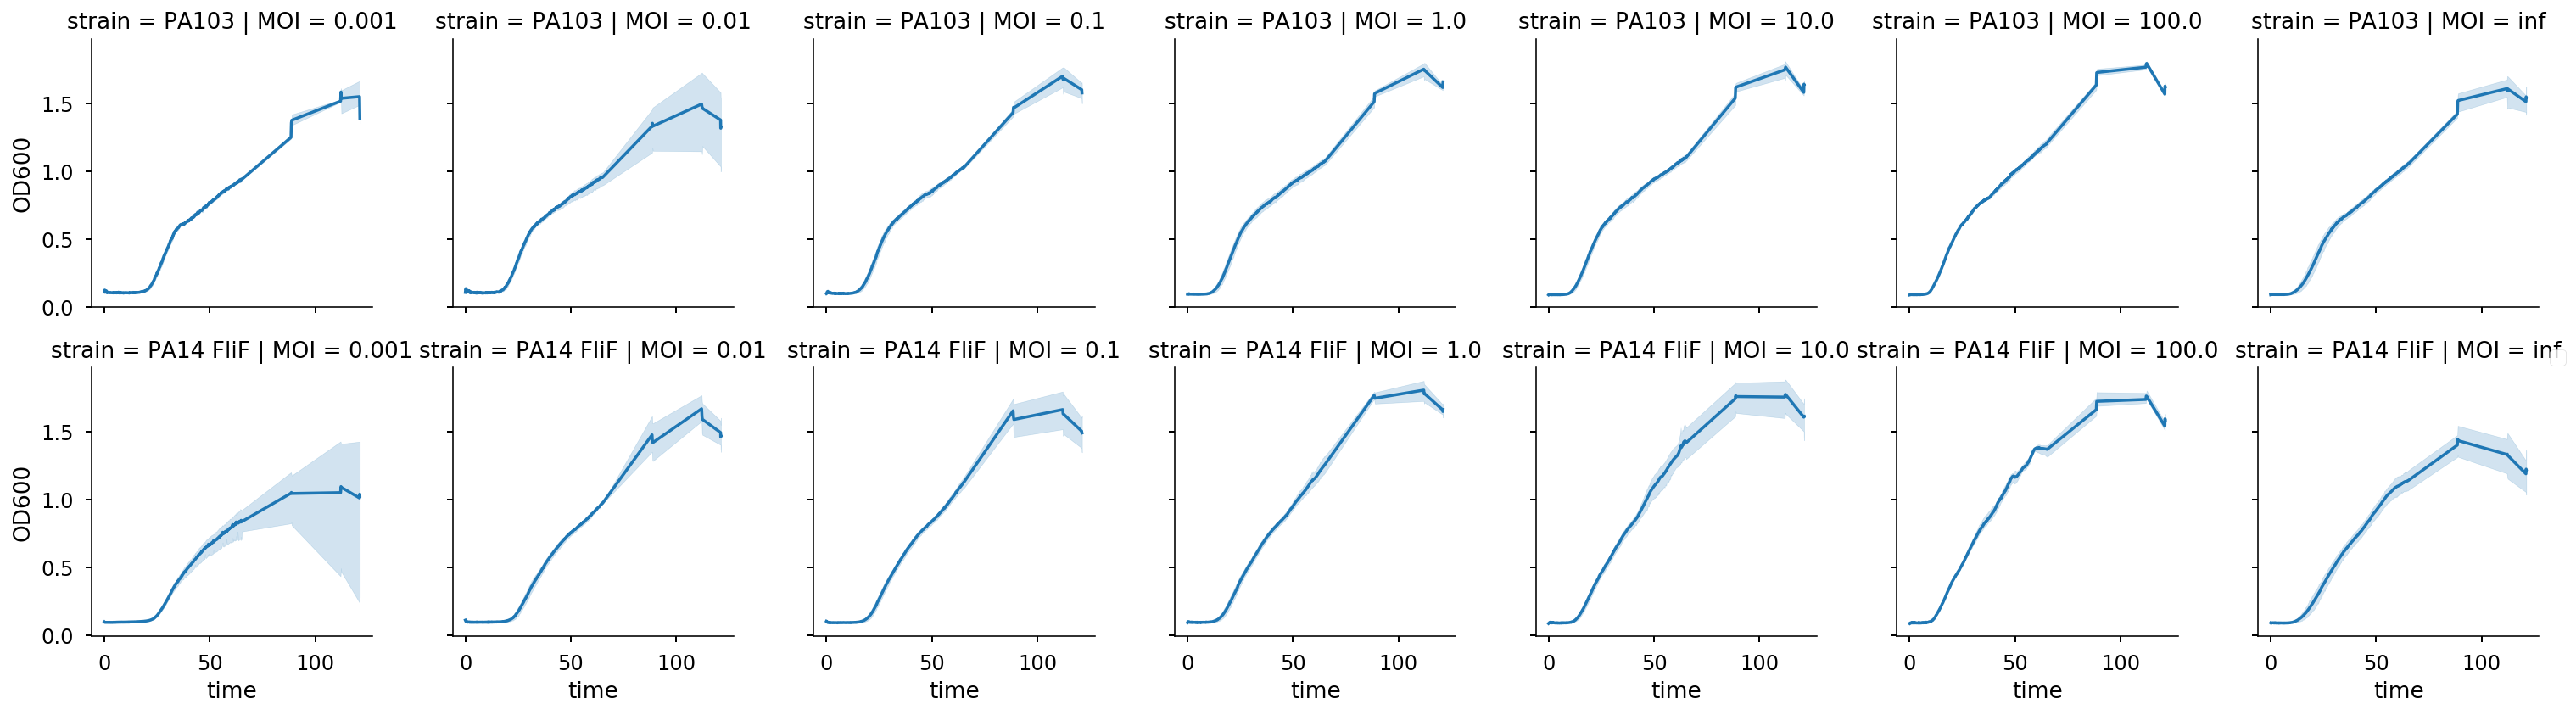

In [183]:
g = sns.FacetGrid(data=data,
                  col='MOI',row='strain',
                  palette='viridis')
g.map_dataframe(sns.lineplot,'time','OD600',legend='full')
g.add_legend()
g.fig.tight_layout()

/Users/caseygrun/miniconda3/envs/kaz_lab_workshop/lib/python3.6/site-packages/matplotlib/colors.py:956: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


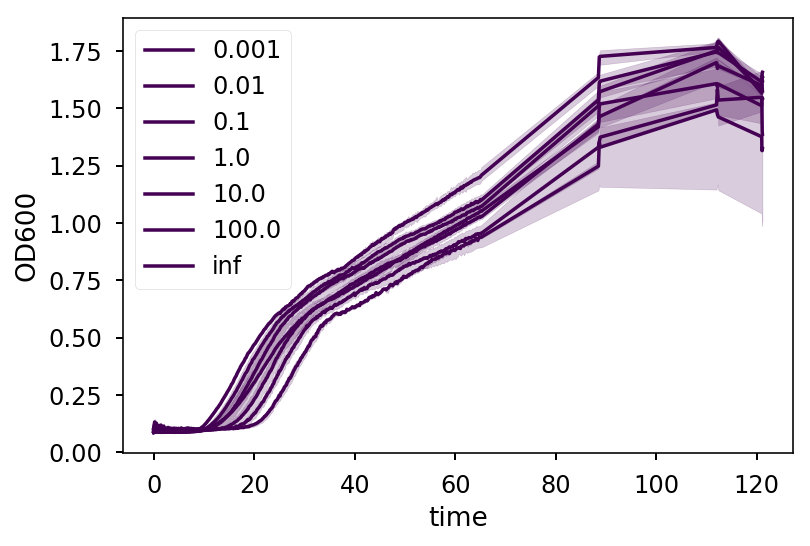

In [191]:
g = sns.lineplot(data=data.query("strain == 'PA103' & MOI < float('inf')"),
                 x='time',y='OD600',hue='MOI',legend='full',palette='viridis')

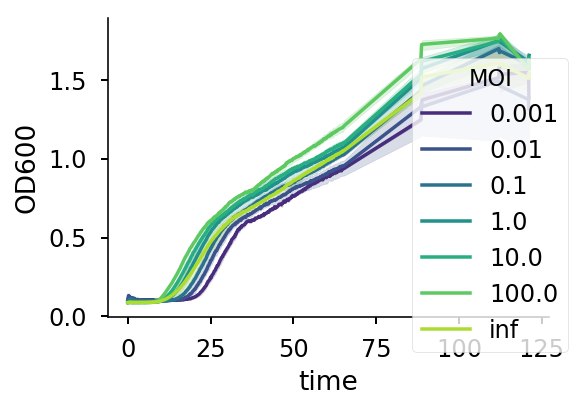

In [189]:
g = sns.FacetGrid(data=data.query("strain == 'PA103'"),
                  hue='MOI', palette='viridis', legend_out=True)
g.map_dataframe(sns.lineplot,'time','OD600',legend='full')
g.add_legend()
g.fig.tight_layout()

In [190]:
sns.lineplot?

### Appendix

In [170]:
import io
carrie_platemap = pd.read_csv(io.StringIO("""
well , Pa_inoculum , strain    , Ac_inoculum
A1   , 1e3        , PA103     , 0
A2   , 1e3        , PA103     , 0
A3   , 1e3        , PA103     , 0
A4   , 1e4        , PA103     , 0
A5   , 1e4        , PA103     , 0
A6   , 1e4        , PA103     , 0
A7   , 1e4        , PA14 FliF , 0
A8   , 1e4        , PA14 FliF , 0
A9   , 1e4        , PA14 FliF , 0
A10  , 1e3        , PA14 FliF , 0
A11  , 1e3        , PA14 FliF , 0
A12  , 1e3        , PA14 FliF , 0
B1   , 100         , PA103     , 0
B2   , 100         , PA103     , 0
B3   , 100         , PA103     , 0
B4   , 10          , PA103     , 0
B5   , 10          , PA103     , 0
B6   , 10          , PA103     , 0
B7   , 100         , PA14 FliF , 0
B8   , 100         , PA14 FliF , 0
B9   , 100         , PA14 FliF , 0
B10  , 10          , PA14 FliF , 0
B11  , 10          , PA14 FliF , 0
B12  , 10          , PA14 FliF , 0
C1   , 1e3        , PA103     , 100
C2   , 1e3        , PA103     , 100
C3   , 1e3        , PA103     , 100
C4   , 1e4        , PA103     , 100
C5   , 1e4        , PA103     , 100
C6   , 1e4        , PA103     , 100
C7   , 1e4        , PA14 FliF , 100
C8   , 1e4        , PA14 FliF , 100
C9   , 1e4        , PA14 FliF , 100
C10  , 1e3        , PA14 FliF , 100
C11  , 1e3        , PA14 FliF , 100
C12  , 1e3        , PA14 FliF , 100
D1   , 100         , PA103     , 100
D2   , 100         , PA103     , 100
D3   , 100         , PA103     , 100
D4   , 10          , PA103     , 100
D5   , 10          , PA103     , 100
D6   , 10          , PA103     , 100
D7   , 100         , PA14 FliF , 100
D8   , 100         , PA14 FliF , 100
D9   , 100         , PA14 FliF , 100
D10  , 10          , PA14 FliF , 100
D11  , 10          , PA14 FliF , 100
D12  , 10          , PA14 FliF , 100
E1   , 1e3        , PA103     , 1e3
E2   , 1e3        , PA103     , 1e3
E3   , 1e3        , PA103     , 1e3
E4   , 1e4        , PA103     , 1e3
E5   , 1e4        , PA103     , 1e3
E6   , 1e4        , PA103     , 1e3
E7   , 1e4        , PA14 FliF , 1e3
E8   , 1e4        , PA14 FliF , 1e3
E9   , 1e4        , PA14 FliF , 1e3
E10  , 1e3        , PA14 FliF , 1e3
E11  , 1e3        , PA14 FliF , 1e3
E12  , 1e3        , PA14 FliF , 1e3
F1   , 100         , PA103     , 1e3
F2   , 100         , PA103     , 1e3
F3   , 100         , PA103     , 1e3
F4   , 10          , PA103     , 1e3
F5   , 10          , PA103     , 1e3
F6   , 10          , PA103     , 1e3
F7   , 100         , PA14 FliF , 1e3
F8   , 100         , PA14 FliF , 1e3
F9   , 100         , PA14 FliF , 1e3
F10  , 10          , PA14 FliF , 1e3
F11  , 10          , PA14 FliF , 1e3
F12  , 10          , PA14 FliF , 1e3
G1   , 1e3        , PA103     , 1e4
G2   , 1e3        , PA103     , 1e4
G3   , 1e3        , PA103     , 1e4
G4   , 1e4        , PA103     , 1e4
G5   , 1e4        , PA103     , 1e4
G6   , 1e4        , PA103     , 1e4
G7   , 1e4        , PA14 FliF , 1e4
G8   , 1e4        , PA14 FliF , 1e4
G9   , 1e4        , PA14 FliF , 1e4
G10  , 1e3        , PA14 FliF , 1e4
G11  , 1e3        , PA14 FliF , 1e4
G12  , 1e3        , PA14 FliF , 1e4
H1   , 100         , PA103     , 1e4
H2   , 100         , PA103     , 1e4
H3   , 100         , PA103     , 1e4
H4   , 10          , PA103     , 1e4
H5   , 10          , PA103     , 1e4
H6   , 10          , PA103     , 1e4
H7   , 100         , PA14 FliF , 1e4
H8   , 100         , PA14 FliF , 1e4
H9   , 100         , PA14 FliF , 1e4
H10  , 10          , PA14 FliF , 1e4
H11  , 10          , PA14 FliF , 1e4
H12  , 10          , PA14 FliF , 1e4
"""))
carrie_platemap.columns = carrie_platemap.columns.map(str.strip)
carrie_platemap = carrie_platemap.applymap(lambda x: str.strip(x) if isinstance(x, str) else x)
carrie_platemap = carrie_platemap.set_index('well')
np.all(platemap.drop(columns=['row','column']).sort_index().sort_index(axis=1) == carrie_platemap.sort_index().sort_index(axis=1))

True

In [101]:
data = df1
offset = 0

for data in [df1, df2, df3]:

    # Extract temperature vs. time as separate variable, then drop (delete)
    # it from the main data frame
    temps = df.loc['Temp. [°C]',:]
    df = df.drop('Temp. [°C]')

    # likewise, extract the seconds column
    time_h = df.loc['Time [hrs]',:]
    df = df.drop('Time [hrs]')

    # convert columns to hours, and add offset
    df.columns = (df.columns / 3600) + offset

    # the offset for the next table will be the last time point for this table
    offset = df.columns[-1]

    # collect df into "tidy" format, with one row per observation, 
    # one column for each variable (well, time, OD600)
    df.columns = df.columns.rename('time')
    df.index = df.index.rename('well')
    df = df.reset_index()
    df = df.melt(id_vars=['well'],value_name='OD600')

KeyError: 'the label [Temp. [°C]] is not in the [index]'